# Text Analysis

This exercise extracts the title and summary of Wikipedia categories **[Euphemisms](https://en.wikipedia.org/wiki/Category:Euphemisms)** (contains 161 pages) and **[Swiss brands](https://en.wikipedia.org/wiki/Category:Swiss_brands)** (contains 184 pages). The extracted data is then cleaned, augmentated and analyzed.




##Setup

In [21]:
#!pip install wikipedia-api
#!pip install nltk

In [2]:
import wikipediaapi
import pandas as pd
import nltk
import spacy 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import brown
import string
import re
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 30

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


## Collect data from Wikipedia 🔍
The chosen categories are **Euphemisms** and **Swiss brands** because I want to learn about the true meaning behind phrases like "Netflix and chill" and also to get to know what potential future employers there are!

In [3]:
# Get members for a category together with a short description
def members_collector(category):
      mdict = {}
      categorymembers = category.categorymembers
      for c in categorymembers.values():
        if c.ns == 0:                                                            # Exclude categories within the category
          mdict[c.title] = c.summary
      return mdict

In [4]:
# Let's collect Euphemisms
wiki = wikipediaapi.Wikipedia('en')
euphemisms = wiki.page("Category:Euphemisms")
euphemisms_dict = members_collector(euphemisms)

In [5]:
# Create dataframe
euphemisms_df = pd.DataFrame([euphemisms_dict.keys(), euphemisms_dict.values()]).T
euphemisms_df.columns = ['Name', 'Description']
euphemisms_df.insert(1, 'Category', "Euphemism")
euphemisms_df = euphemisms_df.iloc[1: , :]

In [6]:
# Let's collect Swiss brands
swiss_brands = wiki.page("Category:Swiss brands")
swiss_brands_dict = members_collector(swiss_brands)

In [7]:
# Create dataframe
swiss_brands_df = pd.DataFrame([swiss_brands_dict.keys(), swiss_brands_dict.values()]).T
swiss_brands_df.columns = ['Name', 'Description']
swiss_brands_df.insert(1, 'Category', "Swiss brands")
swiss_brands_df = swiss_brands_df.iloc[1: , :]

In [13]:
#combine two dataframes
wiki_df = pd.concat([euphemisms_df, swiss_brands_df], ignore_index=True)
wiki_styler = wiki_df[145:155].style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
wiki_styler

,Name,Category,Description
145,Unparliamentary language,Euphemism,"Parliaments and legislative bodies around the world impose certain rules and standards during debates. Tradition has evolved that there are words or phrases that are deemed inappropriate for use in the legislature whilst it is in session. In a Westminster system, this is called unparliamentary language and there are similar rules in other kinds of legislative systems. This includes, but is not limited to, the suggestion of dishonesty or the use of profanity. Most unacceptable is any insinuation that another member is dishonourable. So, for example, in the British House of Commons any direct reference to a member as lying is unacceptable. A conventional alternative, when necessary, is to complain of a ""terminological inexactitude"".Exactly what constitutes unparliamentary language is generally left to the discretion of the Speaker of the House. Part of the speaker's job is to enforce the assembly's debating rules, one of which is that members may not use ""unparliamentary"" language. That is, their words must not offend the dignity of the assembly. In addition, legislators in some places are protected from prosecution and civil actions by parliamentary immunity which generally stipulates that they cannot be sued or otherwise prosecuted for anything spoken in the legislature. Consequently, they are expected to avoid using words or phrases that might be seen as abusing that immunity. Like other rules that have changed with the times, speakers' rulings on unparliamentary language reflect the tastes of the period. The Table, the annual journal of the Society of Clerks-at-the-Table in Commonwealth Parliaments, includes a list of expressions ruled unparliamentary that year in the national and regional assemblies of its members."
146,Vogelfrei,Euphemism,"Vogelfrei (Dutch: Vogelvrij and Afrikaans: Voëlvry) in German usage denotes the status of a person on whom a legal penalty of outlawry has been imposed. However, the original meaning of the term referred to independence, being ""free as a bird"";"
147,Wardrobe malfunction,Euphemism,"A wardrobe malfunction is a clothing failure that accidentally or intentionally exposes a person's intimate parts. It is different from deliberate incidents of indecent exposure or public flashing. Justin Timberlake first used the term when apologizing for the Super Bowl XXXVIII halftime show controversy during the 2004 Grammy Awards. The phrase ""wardrobe malfunction"" was in turn used by the media to refer to the incident and entered pop culture. There was a long history of such incidents before the term was coined and it has since become common."
148,Wetwork,Euphemism,"Wetwork (Russian: мокрое дело, tr. mokroye delo) is a euphemism for murder or assassination that alludes to spilling blood. The expression and the similar wet job, wet affair, or wet operation are all calques of Russian terms for such activities and can be traced to criminal slang from at least the 19th century and originally meant robbery that involved murder, or spilling blood. The operations are reputed to have been handled by the CIA and by the KGB's SpecBureau 13 (Spets Byuro 13), colorfully known as the ""Department of Wet Affairs"" (Otdel mokrykh del)."
149,Without the right of correspondence,Euphemism,"""Without the right of correspondence"" (WRC) (Russian: Без права переписки, abbreviated as БПП in official documents) was a clause in a sentence of many political repressions victims of Stalinist Great Purges in Soviet Union that implied death. It was used to keep family relatives of those executed uncertain as to the fate or whereabouts of the victims."
150,Word taboo,Euphemism,"Word taboo, also called taboo language, language taboo or linguistic taboo is a kind of taboo that involves restricting the use of words or other parts of language due to social constraints. This may be due to a taboo on specific parts of the language itself (such as certain words, or soun

## Clean the collected data 🧼
The data scraped is pretty clean already except there are a few unwanted strings

In [14]:
#In some of the descriptions, there is the escape character "\n" or "== References ==" at the end of some descriptions. 
#Let's clean that up
def clean_description(text):
    text = re.sub('\n|== References ==',"", text)
    return text.strip()

wiki_df["Description"] = wiki_df["Description"].apply(clean_description)

## Add text features 📝

### Get word count for title and description
I choose to get the word count instead of string length of the text becasue I believe the number of words is more useful than the string length in this use case.

In [15]:
#Add column - Word count for Title
wiki_df["title_word_count"] = wiki_df["Name"].apply(lambda x: len(x.split()))

#Add column - Word count for Description
wiki_df["description_word_count"] = wiki_df["Description"].apply(lambda x: len(x.split()))

### Tokenization & stop words removal

In [17]:
#first, we tokenize the description
wiki_df["tokenized_description"] = wiki_df["Description"].apply(word_tokenize)

#then, we remove stopwords and punctuations from the tokens because they are not important in this exercise
stop_words = set(stopwords.words('english'))
wiki_df['tokens_without_stopwords'] = wiki_df['tokenized_description'].apply(lambda x: [w for w in x if not w.lower() in stop_words if w.isalnum()])

#afterwards, we drop the column "tokenized_description"
wiki_df = wiki_df.drop("tokenized_description", axis = 1)

### Calculate TTR

In [18]:
#Get TTR
def ttr_calculator(tokens_list):
  tokens_len = len(tokens_list)
  type_len = len(set(tokens_list))
  ttr = type_len/tokens_len
  return ttr

#add TTR column
wiki_df["TTR"] = wiki_df["tokens_without_stopwords"].apply(ttr_calculator)

### Add POS Tags

In [19]:
#add POS tags column
wiki_df["POS"] = wiki_df["tokens_without_stopwords"].apply(nltk.pos_tag)

In [20]:
wiki_df.head()

,Name,Category,Description,title_word_count,description_word_count,tokens_without_stopwords,TTR,POS
0,Acceptable loss,Euphemism,"An acceptable loss, also known as acceptable damage or acceptable casualties, is a military euphemism used to indicate casualties or destruction inflicted by the enemy that is considered minor or ...",2,225,"[acceptable, loss, also, known, acceptable, damage, acceptable, casualties, military, euphemism, used, indicate, casualties, destruction, inflicted, enemy, considered, minor, tolerable, combat, si...",0.786325,"[(acceptable, JJ), (loss, NN), (also, RB), (known, VBN), (acceptable, JJ), (damage, NN), (acceptable, JJ), (casualties, NNS), (military, JJ), (euphemism, NN), (used, VBN), (indicate, JJ), (casualt..."
1,Accounting irregularity,Euphemism,"An accounting irregularity is an entry or statement that does not conform to the normal laws, practises and rules of the accounting profession, having the deliberate intent to deceive or defraud. ...",2,95,"[accounting, irregularity, entry, statement, conform, normal, laws, practises, rules, accounting, profession, deliberate, intent, deceive, defraud, Accounting, irregularities, consist, intentional...",0.857143,"[(accounting, NN), (irregularity, NN), (entry, NN), (statement, NN), (conform, NN), (normal, JJ), (laws, NNS), (practises, NNS), (rules, NNS), (accounting, VBG), (profession, NN), (deliberate, VB)..."
2,Sex industry,Euphemism,The sex industry (also called the sex trade) consists of businesses that either directly or indirectly provide sex-related products and services or adult entertainment. The industry includes activ...,2,127,"[sex, industry, also, called, sex, trade, consists, businesses, either, directly, indirectly, provide, products, services, adult, entertainment, industry, includes, activities, involving, direct, ...",0.717647,"[(sex, NN), (industry, NN), (also, RB), (called, VBD), (sex, NN), (trade, NN), (consists, VBZ), (businesses, NNS), (either, CC), (directly, RB), (indirectly, RB), (provide, VBP), (products, NNS), ..."
3,Allergic salute,Euphemism,"The allergic salute (sometimes called the nasal salute) is the characteristic and sometimes habitual gesture of wiping and/or rubbing the nose in an upwards or transverse manner with the fingers, ...",2,106,"[allergic, salute, sometimes, called, nasal, salute, characteristic, sometimes, habitual, gesture, wiping, rubbing, nose, upwards, transverse, manner, fingers, palm, back, hand, termed, salute, up...",0.775862,"[(allergic, JJ), (salute, NN), (sometimes, RB), (called, VBD), (nasal, JJ), (salute, NN), (characteristic, JJ), (sometimes, RB), (habitual, JJ), (gesture, NN), (wiping, VBG), (rubbing, VBG), (nose..."
4,Alternative facts,Euphemism,"""Alternative facts"" was a phrase used by U.S. Counselor to the President, Kellyanne Conway, during a Meet the Press interview on January 22, 2017, in which she defended White House Press Secretary...",2,186,"[Alternative, facts, phrase, used, Counselor, President, Kellyanne, Conway, Meet, Press, interview, January, 22, 2017, defended, White, House, Press, Secretary, Sean, Spicer, false, statement, att...",0.771186,"[(Alternative, JJ), (facts, NNS), (phrase, VBP), (used, VBN), (Counselor, NNP), (President, NNP), (Kellyanne, NNP), (Conway, NNP), (Meet, NNP), (Press, NNP), (interview, NN), (January, NNP), (22, ..."


## Exploratory Data & Text Analysis 🕵️‍♂️

### Foreign characters detection
I want to find out what kind of foreign characters there are.

In [ ]:
#check foreign characters using regex
def foreign_char_check(tokens_list):
  regex = "[^((0-9)|(a-z)|(A-Z)|\s)]"
  foreign_char = [token for token in tokens_list if bool(re.search(regex, token))]
  return foreign_char

In [ ]:
#add a new column for foreign words
wiki_df["foreign_words"] = wiki_df["tokens_without_stopwords"].apply(foreign_char_check)

In [ ]:
#what are the foreign words contained in the dataframe?
pd.set_option('max_rows', 100)
wiki_df[wiki_df["foreign_words"].apply(lambda x: len(x))>0]["foreign_words"]


6                                                                                                                                                          [ˈaʁbaɪt, ˈmaxt, ˈfʁaɪ]
9                                                                                                                                                [Ástandið, ástandsbörn, Keflavík]
13                                                                                                                                                              [Bandenbekämpfung]
22                                                                                                                                                  [В, административном, порядке]
27                                                                                                                                                                        [Grimké]
29                                                                                                       

In [ ]:
#What about the FW identified by nltk POS?
for i in wiki_df["POS"]:
  for j in i:
    if j[1] == "FW":
      print(j)

('disrupt', 'FW')
('mammoplasty', 'FW')
('kanji', 'FW')
('endonym', 'FW')
('en', 'FW')
('persona', 'FW')
('de', 'FW')
('hereje', 'FW')
('de', 'FW')
('muger', 'FW')
('de', 'FW')
('en', 'FW')
('persona', 'FW')
('en', 'FW')
('de', 'FW')
('en', 'FW')
('año', 'FW')
('de', 'FW')
('noun', 'FW')
('de', 'FW')
('de', 'FW')
('del', 'FW')
('rifle', 'FW')
('de', 'FW')
('fer', 'FW')


In [ ]:
#Now I wonder how POS nltk tags 慰安婦  
for i in wiki_df["POS"]:
  for j in i:
    if j[0] == "慰安婦":
      print(j)

('慰安婦', 'JJ')


nltk tags it as an adjective, which is not accurate at all. It should be a foreign word and it is a noun in Chinese.  
The function with regex can detect more foreign words than the POS tagging but it fails to detect words like "de", 
which contain English alphabets but is not English.

### Word cloud

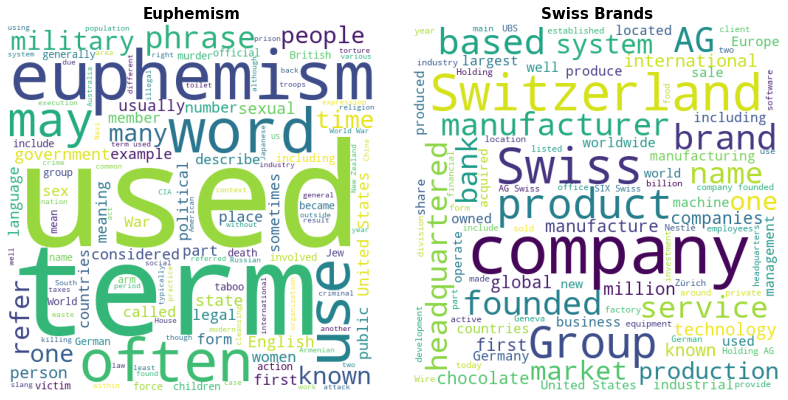

In [ ]:
#Let's see the word clouds for Euphemisms and Swiss brands respectively

rows=1
cols=2

row=0 
col=0


#put all euphemism tokens into one string
euphemism_tokens = wiki_df[wiki_df["Category"] == "Euphemism"]["tokens_without_stopwords"]
euphemism_str = ""
for li in euphemism_tokens:
  string = " ".join(li)
  euphemism_str  += string

#put all swiss brands tokens into one string
swiss_brands_tokens = wiki_df[wiki_df["Category"] == "Swiss brands"]["tokens_without_stopwords"]
swiss_brands_str = ""
for li in swiss_brands_tokens:
  string = " ".join(li)
  swiss_brands_str  += string

#plot word clouds
titles = ['Euphemism', 'Swiss Brands']
w = [euphemism_str, swiss_brands_str]
fig, ax = plt.subplots(1, 2, figsize=(12.5,6.5))

for i in range(2):
  ax[col].imshow(WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(w[i]))
  ax[col].axis("off")
  ax[col].set_title(titles[i], fontdict={'fontsize': 15, 'fontweight' : 'bold'})
  row=row+1
  if row==rows:
     row=0
     col=col+1

plt.subplots_adjust(left=0.07, right=0.93, wspace=0.1, hspace=0.0,top=0.94,bottom=0.09)
plt.show() 

### Polarity & Subjectivity

In [ ]:
def polarity(description):
    return TextBlob(description).sentiment[0]
  
def subjectivity(description):
    return TextBlob(description).sentiment[1]

In [ ]:
wiki_df["polarity"] = wiki_df["Description"].apply(polarity)
wiki_df["subjectivity"] = wiki_df["Description"].apply(subjectivity)

In [ ]:
wiki_df.head()

,Name,Category,Description,title_word_count,description_word_count,tokenized_description,tokens_without_stopwords,TTR,POS,foreign_words,polarity,subjectivity
0,Acceptable loss,Euphemism,"An acceptable loss, also known as acceptable damage or acceptable casualties, is a military euphemism used to indicate casualties or destruction inflicted by the enemy that is considered minor or tolerable. In combat situations, leaders have to often choose between options where no one solution is perfect and all choices will lead to casualties or other costs to their own troops.A small scale ...",2,225,"[An, acceptable, loss, ,, also, known, as, acceptable, damage, or, acceptable, casualties, ,, is, a, military, euphemism, used, to, indicate, casualties, or, destruction, inflicted, by, the, enemy, that, is, considered, minor, or, tolerable, ., In, combat, situations, ,, leaders, have, to, often, choose, between, options, where, no, one, solution, is, perfect, and, all, choices, will, lead, to...","[acceptable, loss, also, known, acceptable, damage, acceptable, casualties, military, euphemism, used, indicate, casualties, destruction, inflicted, enemy, considered, minor, tolerable, combat, situations, leaders, often, choose, options, one, solution, perfect, choices, lead, casualties, costs, small, scale, practical, example, might, advancement, troops, halted, minefield, many, military, op...",0.786325,"[(acceptable, JJ), (loss, NN), (also, RB), (known, VBN), (acceptable, JJ), (damage, NN), (acceptable, JJ), (casualties, NNS), (military, JJ), (euphemism, NN), (used, VBN), (indicate, JJ), (casualties, NNS), (destruction, NN), (inflicted, VBN), (enemy, RB), (considered, VBN), (minor, JJ), (tolerable, JJ), (combat, NN), (situations, NNS), (leaders, NNS), (often, RB), (choose, VBP), (options, NNS...",[],0.125962,0.465064
1,Accounting irregularity,Euphemism,"An accounting irregularity is an entry or statement that does not conform to the normal laws, practises and rules of the accounting profession, having the deliberate intent to deceive or defraud. Accounting irregularities can consist of intentionally misstating amounts and other information in financial statements, or omitting information required to be disclosed. Accounting irregularities are...",2,95,"[An, accounting, irregularity, is, an, entry, or, statement, that, does, not, conform, to, the, normal, laws, ,, practises, and, rules, of, the, accounting, profession, ,, having, the, deliberate, intent, to, deceive, or, defraud, ., Accounting, irregularities, can, consist, of, intentionally, misstating, amounts, and, other, information, in, financial, statements, ,, or, omitting, information...","[accounting, irregularity, entry, statement, conform, normal, laws, practises, rules, accounting, profession, deliberate, intent, deceive, defraud, Accounting, irregularities, consist, intentionally, misstating, amounts, information, financial, statements, omitting, information, required, disclosed, Accounting, irregularities, commonly, distinguished, unintentional, mistakes, irregularities, o...",0.857143,"[(accounting, NN), (irregularity, NN), (entry, NN), (statement, NN), (conform, NN), (normal, JJ), (laws, NNS), (practises, NNS), (rules, NNS), (accounting, VBG), (profession, NN), (deliberate, VB), (intent, NN), (deceive, JJ), (defraud, NN), (Accounting, NNP), (irregularities, NNS), (consist, VBP), (intentionally, RB), (misstating, VBG), (amounts, NNS), (information, NN), (financial, JJ), (sta...",[],-0.068750,0.381250
2,Sex industry,Euphemism,"The sex industry (also called the sex trade) consists of businesses that either directly or indirectly provide sex-related products and services or adult entertainment. The industry includes activities involving direct provision of sex-related services, such as prostitution, strip clubs, host and hostess clubs and sex-related pastimes, such as pornography, sex-oriented men's magazines, sex mov...",2,91,"[The, sex, industry, (, also, called, the, sex, trade, ),

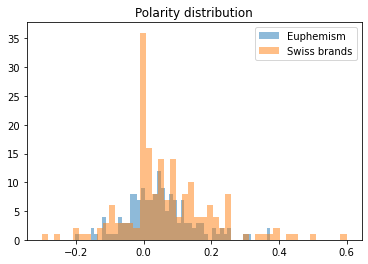

In [ ]:
#plot polarity distribution

x = wiki_df[wiki_df['Category'] == "Euphemism"]['polarity']
y = wiki_df[wiki_df['Category'] == "Swiss brands"]['polarity']

plt.hist(x, bins=50, alpha=0.5, label='Euphemism')
plt.hist(y, bins=50, alpha=0.5, label='Swiss brands')
plt.legend(loc='upper right')
plt.title('Polarity distribution')
plt.show()

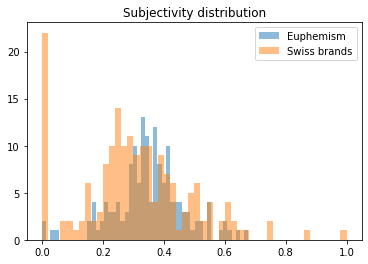

In [ ]:
# #plot subjectivity distribution

x = wiki_df[wiki_df['Category'] == "Euphemism"]['subjectivity']
y = wiki_df[wiki_df['Category'] == "Swiss brands"]['subjectivity']

plt.hist(x, bins=50, alpha=0.5, label='Euphemism')
plt.hist(y, bins=50, alpha=0.5, label='Swiss brands')
plt.legend(loc='upper right')
plt.title('Subjectivity distribution')
plt.show()

In [ ]:
#inspect the description where subjectivity is 1
pd.options.display.max_colwidth = 400
wiki_df.loc[(wiki_df['subjectivity'] == 1)]

,Name,Category,Description,title_word_count,description_word_count,tokenized_description,tokens_without_stopwords,TTR,POS,foreign_words,polarity,subjectivity
160,Au Bijou,Swiss brands,"Au Bijou (Au Bijou Uhren & Schmuck) is the oldest jewellery in Basel, Switzerland, the Huber family business now in 11th generation.In 1656 the goldsmith Martin Huber founded the company producing bijou, the jewellery included in the clothing. Today Patrik-Philipp Huber continues in the tradition and manufactures own jewellery.",2,49,"[Au, Bijou, (, Au, Bijou, Uhren, &, Schmuck, ), is, the, oldest, jewellery, in, Basel, ,, Switzerland, ,, the, Huber, family, business, now, in, 11th, generation.In, 1656, the, goldsmith, Martin, Huber, founded, the, company, producing, bijou, ,, the, jewellery, included, in, the, clothing, ., Today, Patrik-Philipp, Huber, continues, in, the, tradition, and, manufactures, own, jewellery, .]","[Au, Bijou, Au, Bijou, Uhren, Schmuck, oldest, jewellery, Basel, Switzerland, Huber, family, business, 11th, 1656, goldsmith, Martin, Huber, founded, company, producing, bijou, jewellery, included, clothing, Today, Huber, continues, tradition, manufactures, jewellery]",0.806452,"[(Au, NNP), (Bijou, NNP), (Au, NNP), (Bijou, NNP), (Uhren, NNP), (Schmuck, NNP), (oldest, JJS), (jewellery, NN), (Basel, NNP), (Switzerland, NNP), (Huber, NNP), (family, NN), (business, NN), (11th, CD), (1656, CD), (goldsmith, NN), (Martin, NNP), (Huber, NNP), (founded, VBD), (company, NN), (producing, VBG), (bijou, JJ), (jewellery, NN), (included, VBD), (clothing, NN), (Today, NNP), (Huber, N...",[],0.6,1.0


### N-gramming

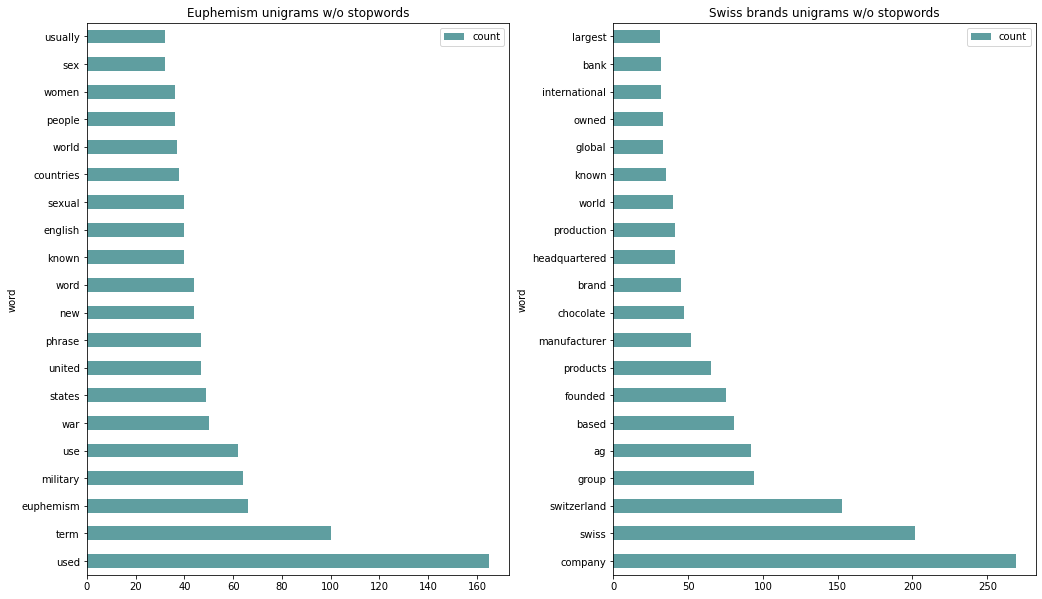

In [ ]:
# Unigrams after stopword removal
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

euphemism_common_words = get_top_n_words(wiki_df[wiki_df['Category'] == "Euphemism"]['Description'], 20)
euphemism_unigrams = pd.DataFrame(euphemism_common_words, columns = ['word' , 'count'])

swiss_brands_common_words = get_top_n_words(wiki_df[wiki_df['Category'] == "Swiss brands"]['Description'], 20)
swiss_brands_unigrams = pd.DataFrame(swiss_brands_common_words, columns = ['word' , 'count'])

figure, axes = plt.subplots(1, 2)
plt.tight_layout()

euphemism_unigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[0], title = "Euphemism unigrams w/o stopwords")
swiss_brands_unigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[1], title = "Swiss brands unigrams w/o stopwords")

We can see *military, war, sex* and *women* are some of the common topic in Euphemism. On the other hand, words like *chocolate* and *bank* are common for Swiss brands, which aligns with the typical impression of Switzerland.

Text(209.74318181818177, 0.5, '')

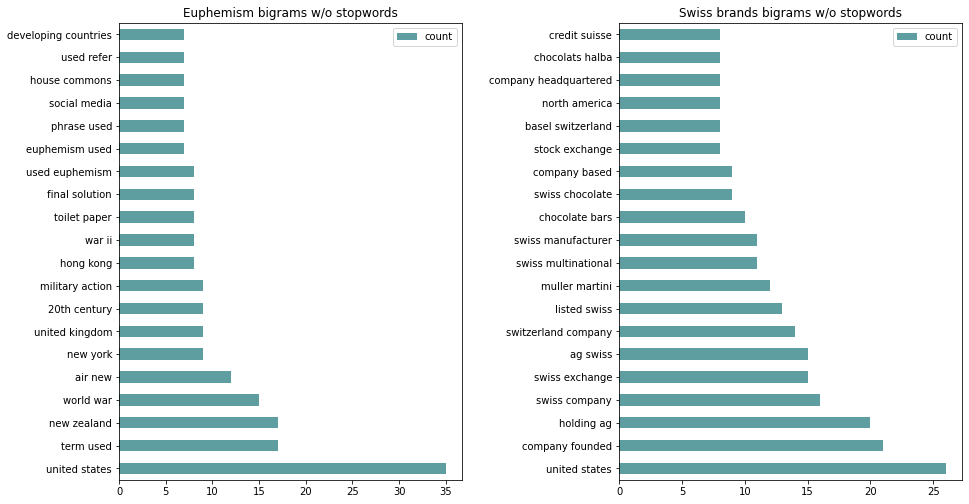

In [ ]:
# Bigrams after stopword removal
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

euphemism_common_bigrams = get_top_n_bigram(wiki_df[wiki_df['Category'] == "Euphemism"]['Description'], 20)
euphemism_bigrams = pd.DataFrame(euphemism_common_bigrams, columns = ['word' , 'count'])

swiss_brands_common_bigrams = get_top_n_bigram(wiki_df[wiki_df['Category'] == "Swiss brands"]['Description'], 20)
swiss_brands_bigrams = pd.DataFrame(swiss_brands_common_bigrams, columns = ['word' , 'count'])

figure, axes = plt.subplots(1, 2)
plt.tight_layout(pad=3.2)

euphemism_bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[0], title = "Euphemism bigrams w/o stopwords").set_ylabel('')
swiss_brands_bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[1], title = "Swiss brands bigrams w/o stopwords").set_ylabel('')

It is a bit surprising that *united states* is not only the most common bigram for Euphemism, but also for Swiss brands.

Text(209.74318181818177, 0.5, '')

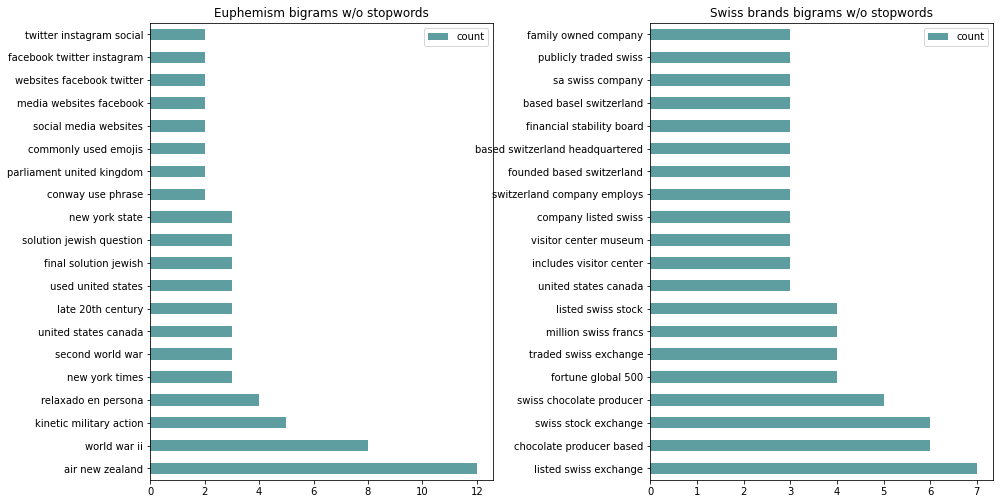

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

euphemism_common_trigrams = get_top_n_trigram(wiki_df[wiki_df['Category'] == "Euphemism"]['Description'], 20)
euphemism_trigrams = pd.DataFrame(euphemism_common_trigrams, columns = ['word' , 'count'])

swiss_brands_common_trigrams = get_top_n_trigram(wiki_df[wiki_df['Category'] == "Swiss brands"]['Description'], 20)
swiss_brands_trigrams = pd.DataFrame(swiss_brands_common_trigrams, columns = ['word' , 'count'])

figure, axes = plt.subplots(1, 2)
plt.tight_layout(pad=3.2)

euphemism_trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[0], title = "Euphemism bigrams w/o stopwords").set_ylabel('')
swiss_brands_trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(15,9), ax=axes[1], title = "Swiss brands bigrams w/o stopwords").set_ylabel('')

### Descriptive Statistics

In [ ]:
wiki_df.describe()

,title_word_count,description_word_count,TTR,polarity,subjectivity
count,336.000000,336.000000,336.000000,336.000000,336.000000
mean,2.029762,123.577381,0.846799,0.058972,0.326018
std,1.084081,97.648073,0.082480,0.117797,0.156708
min,1.000000,9.000000,0.640669,-0.300000,0.000000
25%,1.000000,56.000000,0.786325,0.000000,0.246736
50%,2.000000,95.000000,0.846435,0.044327,0.331937
75%,2.000000,166.500000,0.904762,0.118220,0.409991
max,8.000000,574.000000,1.000000,0.600000,1.000000


## Learnings

NLP has always been the area which interests the most me in data science as I love languages. Although I have read a lot about NLP, it is my first time really get to work with text data. Throughout the exercise, I notice that one has to constantly pay attention to how an algorithm which achieves one goal might causes unwanted results at the same time. For example, the removal of punctuations can make it easier to analyze the text, but sometimes meaningful punctuations like quotation marks used for indicating irony or skepticism play an important role in revealing the true meaning of the text. 
<br>
Sometimes it takes a lot of context to understanding the meaning of a phrase and euphemism is a very good example. "He never married" might seem to only describe a man's marital status, but it actually is used as a euphemism for the deceased having been homosexual. Subjectivity is also not easy to be analyzed. In this exercise, there is one description rated as subjectivity = 1. After inspecting the description, I don't agree with the score at all. <br> 
Another thing I learnt is that the prevalence of code-mixing makes it more challenging to analyze text data. In the exercise, I tried to identify the foreign words with both regex and NLTK tagging. Neither of them was able to do a good job. It is difficult for an algorithm to detect different languages, especially langauges coming from the same root.
<br>
All in all, I enjoyed working on this exercise. Not only was I able to practice the NLP techniques learnt in class, but also to learn more euphemism phrases and Swiss brands which I have not heard of before.